### Bitcoin Pricing Analysis

This notebook will run through EDA, feature engineering and pricing analysis on Bitcoin. We will look at feature engineering and different forecast time scales to see if there is any signal there. This might be in vain due to the volatility of Bitcoin!

Based on Bitstamp exchange Bitcoin pricing data set from Kaggle:

Accessed: 2020/11/01

https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost.core import CatBoostClassifier

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    cross_val_predict,
    TimeSeriesSplit,
    KFold
)

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Helper funcs:
from utils import PurgedGroupTimeSeriesSplit, plot_cv_indices

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 8)

# For reloading helper files on change:
%load_ext autoreload
%autoreload 2


In [2]:
data = pd.read_csv(
    "data/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv",
    parse_dates=["Timestamp"],
    date_parser=lambda x: pd.to_datetime(x, unit="s"),
    index_col="Timestamp",
)
data.columns = data.columns.str.lower().str.replace("[()]", "", regex=True)
data.index.rename("timestamp", inplace=True)
data.shape

(4572257, 7)

Fair bit of data! It is stored by minute frequency but thinking we'll aggregate to a more manageable prediction window (maybe even more stable).

In [3]:
data.head()

,open,high,low,close,volume_btc,volume_currency,weighted_price
timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.isna().sum()

open               1241716
high               1241716
low                1241716
close              1241716
volume_btc         1241716
volume_currency    1241716
weighted_price     1241716
dtype: int64

Lots of NA's! Let's see if it's just early pricing data. Look at how many data points are NA each month, each hour:

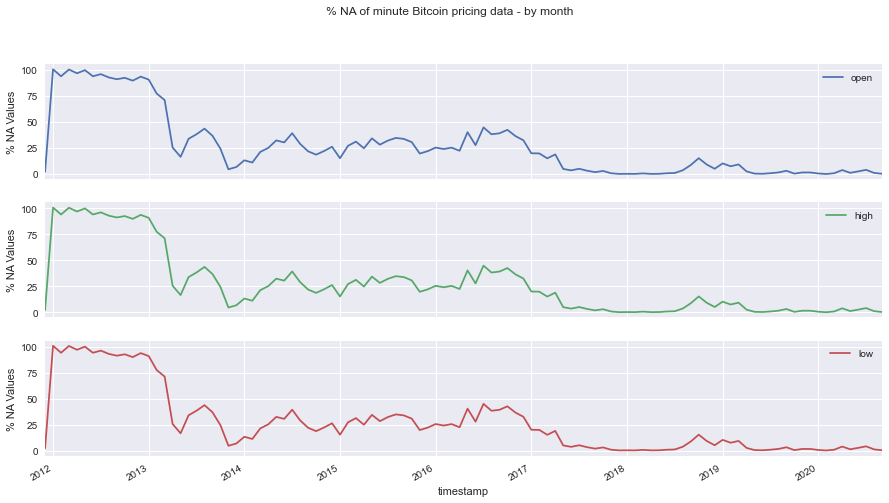

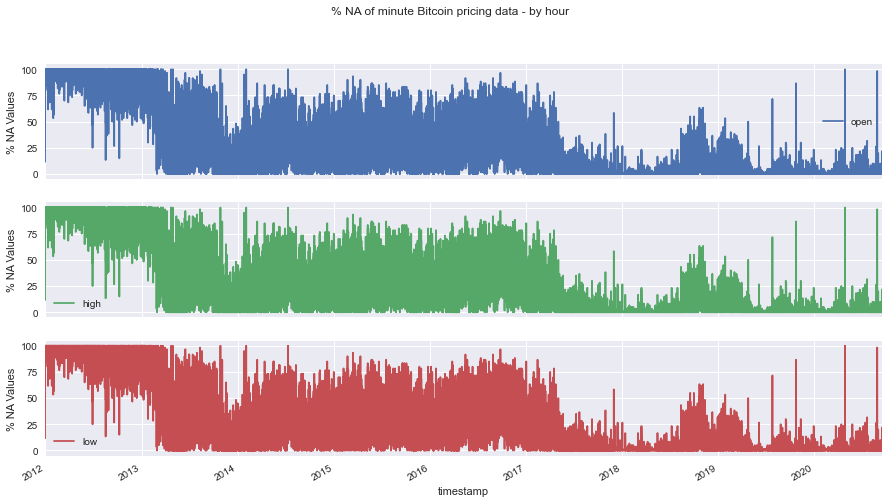

In [5]:
# For each month
(
    data.isna()
    .groupby(pd.Grouper(freq="M"))
    .sum()
    .apply(
        lambda x: 100 * x / (30.4 * 24 * 60)
    )[  # Calculate fraction of monthly values are NA
        ["open", "high", "low"]
    ]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by month",
        ylabel="% NA Values",
    )
)

(
    data.isna()
    .groupby(pd.Grouper(freq="H"))
    .sum()
    .apply(
        lambda x: 100 * x / (60)
    )[  # Calculate fraction of hours reading values are NA
        ["open", "high", "low"]
    ]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by hour",
        ylabel="% NA Values",
    )
);

Ok - a fair bit of NA's to deal with. From the dataset page, this is noted as "no trades having occured". Potentially forward filling these should work then.

We should probably throw out data before ~ 2014. The Bitstamp exchange was founded in 2011 and potentially just didn't have the trade volumes until 2014. 

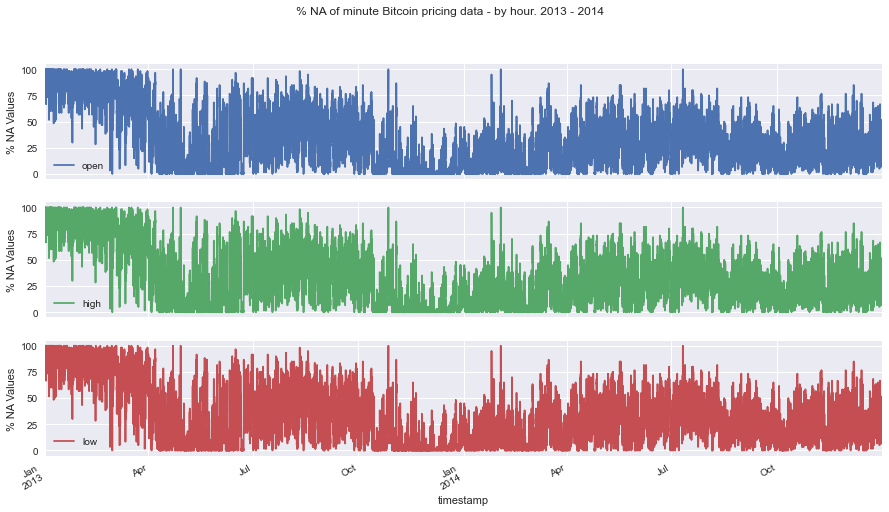

In [6]:
(
    data.isna()
    .groupby(pd.Grouper(freq="H"))
    .sum()
    .apply(
        lambda x: 100 * x / (60)
    )  # Calculate fraction of hours reading values are NA
    .query("index.dt.year == 2013 | index.dt.year == 2014")[["open", "high", "low"]]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by hour. 2013 - 2014",
        ylabel="% NA Values",
    )
);

### Data Splitting and Filling

Let's get rid of the early data, and split into a test set here. We'll leak a bit of knowledge into our test set by splitting before the rebound in 2019, but the dataset after that point appears volatile and should be a relevant test set.

Early history (< 2017) is also before Bitcoin took off in the general public - have to see how/if the model can make effective use of this early data.

**We'll also carry forward to fill NA values for now.**

In [7]:
train_set_split_date = pd.to_datetime("2019/01/01")
start_date = pd.to_datetime("2014/01/01")

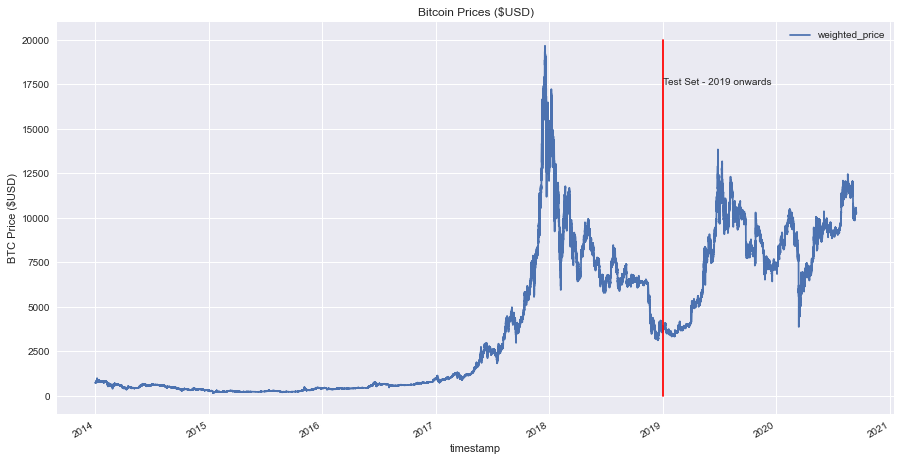

In [8]:
# Carry forward to fill NA's 
data = data.loc[data.index > start_date].fillna(method="ffill")

data.plot(
    kind="line",
    y="weighted_price",
    title="Bitcoin Prices ($USD)",
    ylabel="BTC Price ($USD)",
)
plt.plot([train_set_split_date, train_set_split_date], [0, 20000], "red")
plt.annotate("Test Set - 2019 onwards", (train_set_split_date, 17500));

We'll forward fill NA's for now, and check for gaps in the minute frequency data.

In [9]:
# Quick checks for data NOT at 1 min frequency already:
mask = data.index.to_series().diff() != pd.Timedelta("00:01:00")
data[mask]

,open,high,low,close,volume_btc,volume_currency,weighted_price
timestamp,,,,,,,
2014-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09 21:05:00,272.45,305.0,272.45,291.1,175.837078,50502.066285,287.209426


Only data points not at even 1 minute intervals are first record, and data in January of 2015:

<AxesSubplot:title={'center':'Closing Prices - January 2015'}, xlabel='timestamp', ylabel='USD/BTC'>

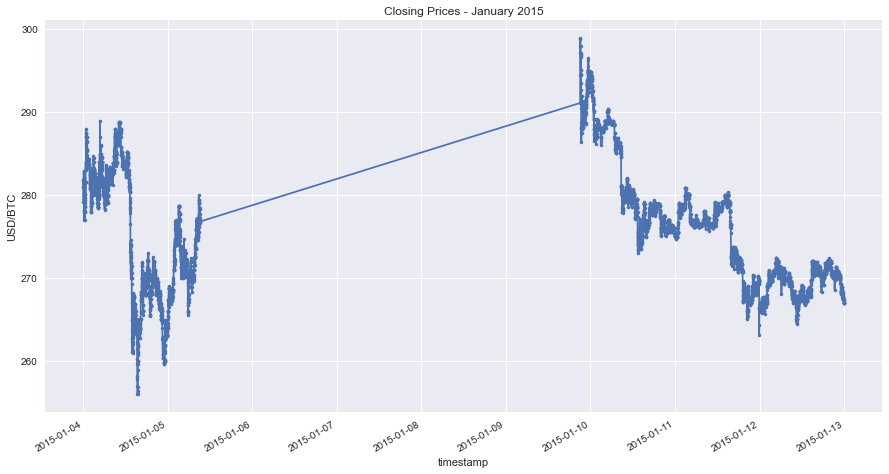

In [10]:
data.loc["2015-01-04":"2015-01-12",:]['close'].plot(title="Closing Prices - January 2015", ylabel="USD/BTC", marker='.')

As this is is ~ 5 days of missing data out of a dataset this size, we'll forward fill this for now. As this is 5 days out of 5 years of the training set, this should be a minor impact, and we can circle back when looking at model residuals if these are causing problems.

<AxesSubplot:title={'center':'Closing Prices - January 2015'}, xlabel='timestamp', ylabel='USD/BTC'>

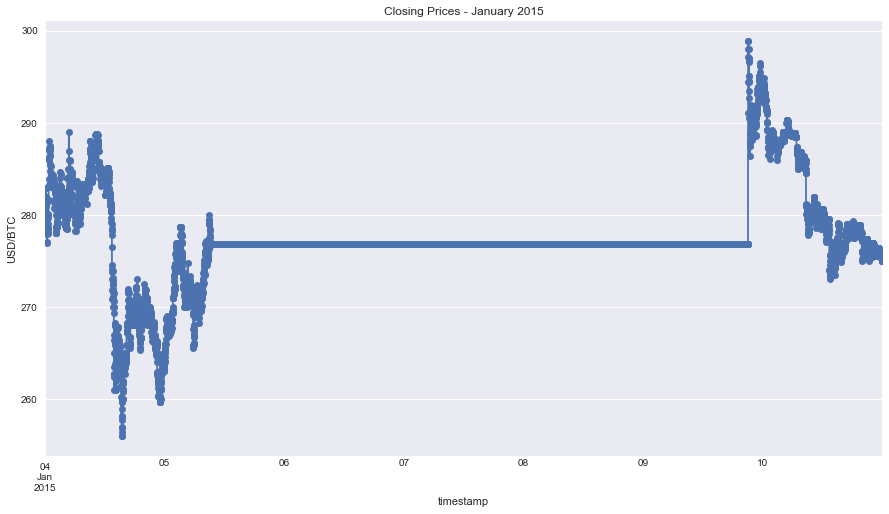

In [11]:
data = data.asfreq(freq="1Min", how='ffill').fillna(method='ffill')
data.loc["2015-01-04":"2015-01-10",:]['close'].plot(title="Closing Prices - January 2015", ylabel="USD/BTC", marker='o')

In [12]:
train_df, test_df = (
    data.loc[data.index < train_set_split_date].dropna(),
    data.loc[data.index >= train_set_split_date].dropna(),
)

In [13]:
test_ratio = round(100 * test_df.shape[0] / (test_df.shape[0] + train_df.shape[0]), 1)
print(f"{test_ratio} % Test Split ")

25.4 % Test Split 


## Modelling

### Baselines

First lets get some baselines. How good could we do with bad forecasts? This can be captured by mean absolute scaled error (MASE [discussed here](https://robjhyndman.com/papers/forecompijf.pdf))  where we will scale by the errors made when just guessing the last known price. This means we evaluate MASE and if we are > 1, we are doing worse than guessing the last known price. Hopefully we can achieve values < 1, but as you step out to forecasting further time horizons (i.e hours or days ahead) this is harder to achieve.

This metric gives a better idea of how much skill we actually have in our forecast - if we look at the early time Bitcoin data, it would be pretty easy to guess the previous days price and be close to correct. In contrast, in the main Bitcoin bubble of 2017/2018 we would have some very bad predictions if we guessed the prior days price.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin


def mase(y, y_pred):
    deltas = np.diff(y)
    d = np.abs(deltas[~np.isnan(deltas)]).sum() / y_pred.shape[0]
    errors = np.abs(y - y_pred)
    return errors.mean() / d


mase_scorer = make_scorer(mase, greater_is_better=False)


def plot_test_forecast(price_pred, price_actual, annotation):
    # Calculate the metric
    mase_predicted = round(mase(price_actual, price_pred), 2)

    # Show relative performance
    fig, ax = plt.subplots()
    price_pred.plot(ax=ax, label="Predicted")
    price_actual.plot(ax=ax, label="Actual")
    ax.annotate(annotation, xy=(0.75, 0.025), xycoords="figure fraction")
    ax.set_title(f"MASE: {mase_predicted}")
    ax.set_ylabel("Price ($USD)")
    ax.legend()

Lets pretend we were going to predict using a moving average and see how this stacks up on different volatility time periods. We'll look at the last year to get a baseline of MASE during more dramatic price movements. We'll also baseline against a narrower window with less volatility and see what MASE we can achieve.

In both cases, we'll use daily pricing for a simpler example.

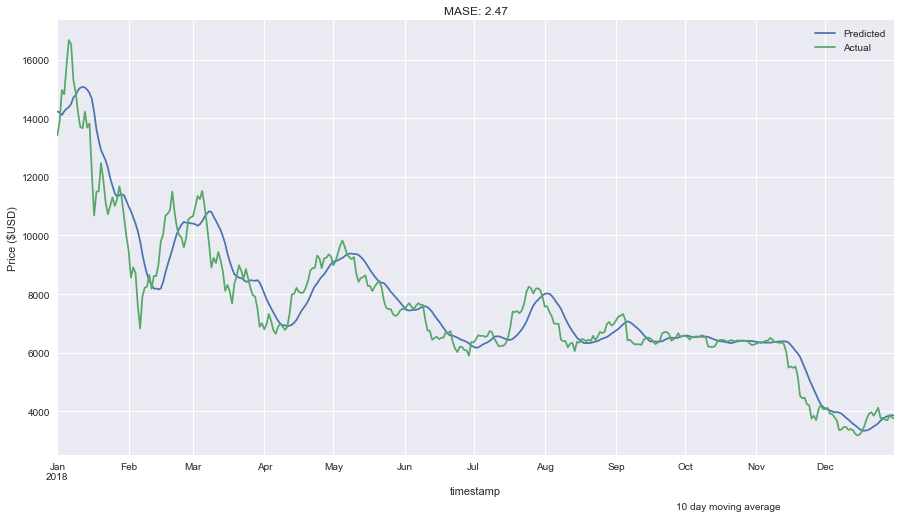

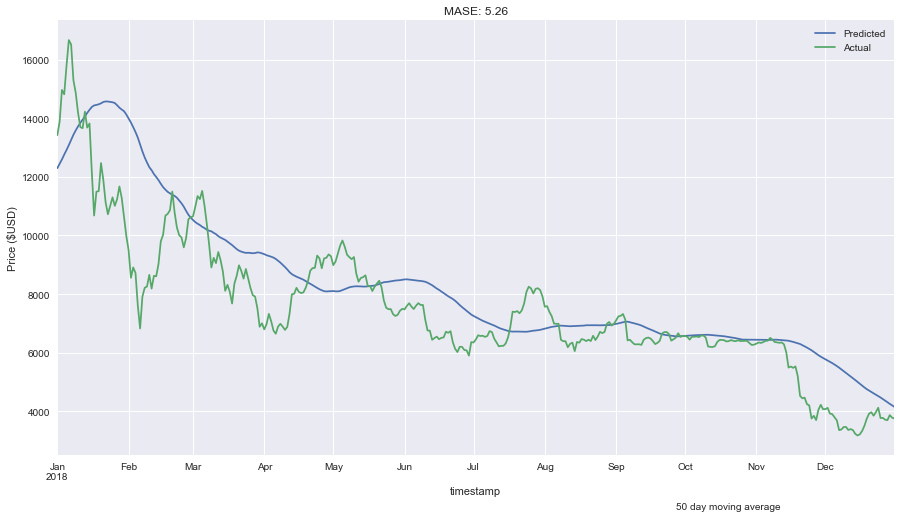

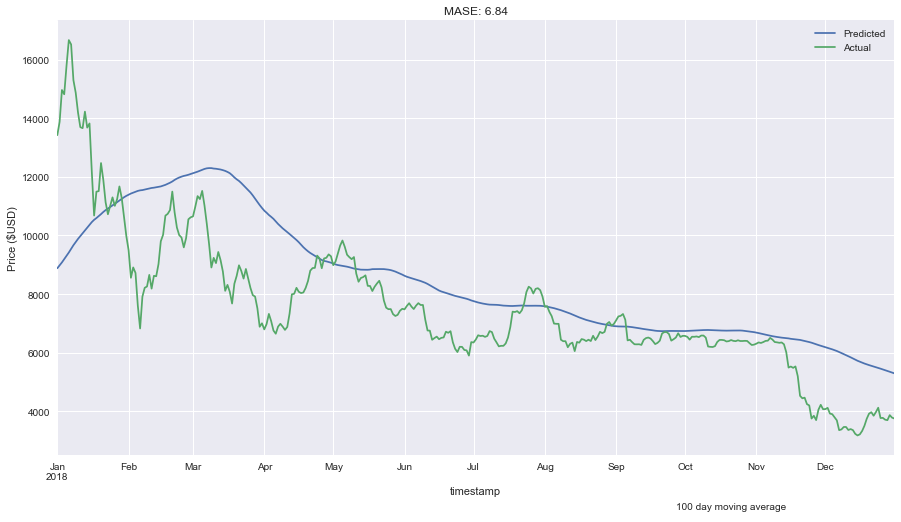

In [15]:
# Near end of dataset
num_steps = 365
sample_df = train_df.groupby(pd.Grouper(freq="D")).mean()

# Note - calculate rolling windows before filtering
for win in [10, 50, 100]:
    plot_test_forecast(
        sample_df["weighted_price"]
        .shift(1)
        .rolling(window=win, min_periods=0)
        .mean()
        .tail(num_steps),
        sample_df["weighted_price"].tail(num_steps),
        annotation=f"{win} day moving average",
    )

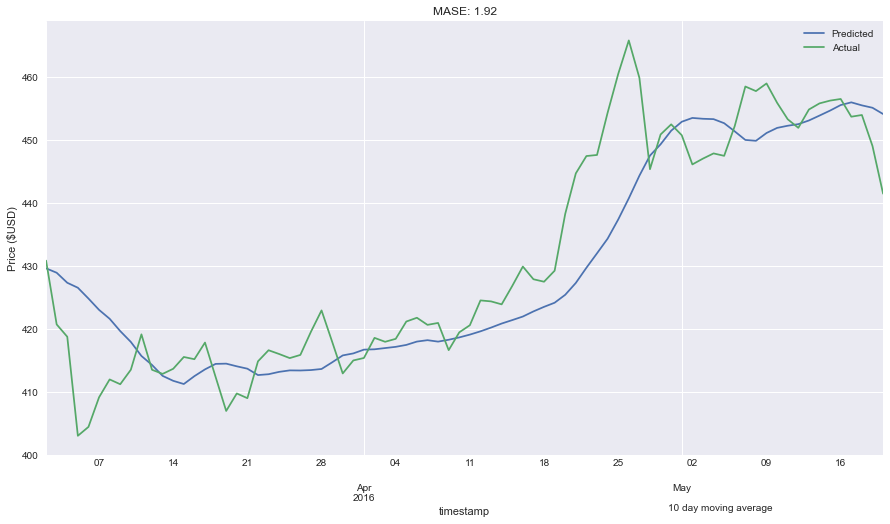

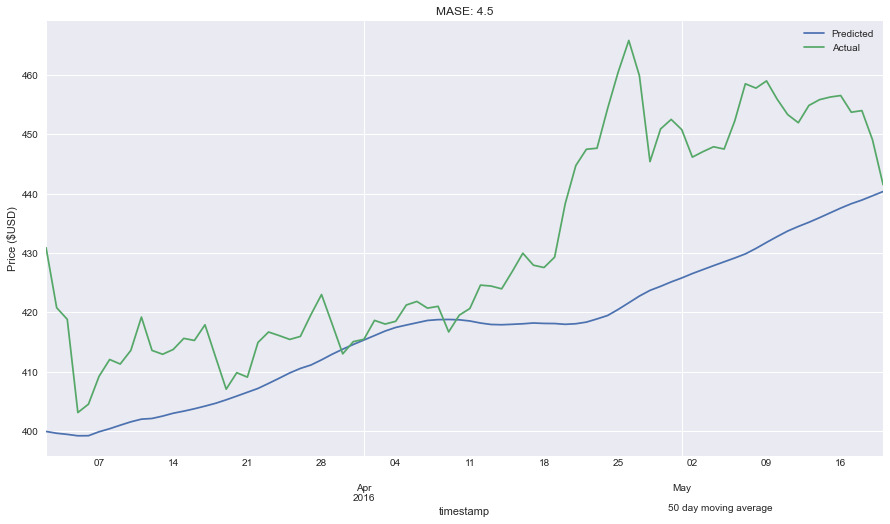

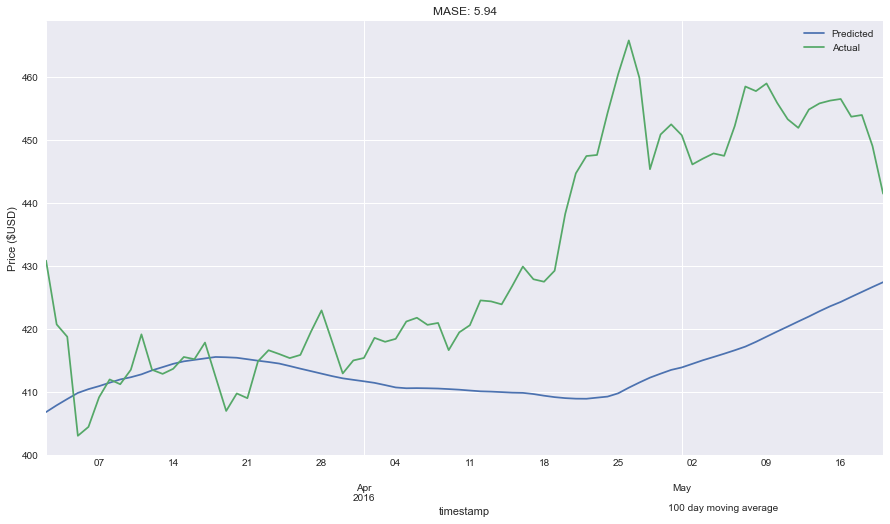

In [16]:
num_steps = 80
sample_df = train_df.groupby(pd.Grouper(freq="D")).mean()
start_date = "2016-03-01"

# Look at a smaller window in the middle with less volatility.
# Note - calculate rolling windows before filtering
for win in [10, 50, 100]:
    plot_test_forecast(
        sample_df["weighted_price"]
        .shift(1)
        .rolling(window=win, min_periods=0)
        .mean()[sample_df.index > start_date]
        .head(num_steps),
        sample_df.loc[sample_df.index > start_date, "weighted_price"].head(num_steps),
        annotation=f"{win} day moving average",
    )

Looks like aggregated to daily pricing, using simplistic moving averages calculated using previous pricing data, the best MASE we can achieve is ~ 1.9. This might change if we are trying to predict with less fidelity (i.e monthly pricing).

One more benchmark we can do - looking at different aggregation levels, how bad do we do if we guess the average price of the training data? Below we aggregate to hourly, daily, weekly and monthly average prices and try to predict on held out future data, using the mean training prices. *We are doing very simplistic aggregation here from minute data upwards by just taking the mean of the data at minute intervals - we'll properly aggregate later in the modelling process.*

In [17]:
dummy_results = pd.DataFrame()
freqs = ["H", "D", "W", "M"]

for f in freqs:

    resample = train_df["weighted_price"].groupby(pd.Grouper(freq=f)).mean().dropna()

    res = cross_validate(
        DummyRegressor(),
        resample.shift(1),
        resample,
        cv=TimeSeriesSplit(n_splits=5),
        scoring=mase_scorer,
        return_train_score=True,
    )

    dummy_results[f"Frequency {f}"] = pd.DataFrame(res).mean()

dummy_results.rename(index={"test_score":"validation_score"})

,Frequency H,Frequency D,Frequency W,Frequency M
fit_time,0.001400,0.001200,0.000801,0.001200
score_time,0.000400,0.000601,0.000200,0.000801
validation_score,-176.656364,-31.902769,-11.627609,-5.764289
train_score,-98.587612,-19.164131,-6.930890,-2.943522


Ok, so no suprise here. Predicting the mean price over our training set ($E[Y|X]$) yields some bad results. Even on a monthly price, we are at a MASE of 2.95 (the negative is added by `sklearn` so we maximize this value).

Next we need to setup how we are going to validate our models. We can't just randomize and do K-fold validation as validation data that occurs in time before training data might leak information into our training set. This would mean we'd be subtly fitting any signals in the validation set that are meant to objectively test our model. So we want validation data to occur **after** training data. `sklearn` has this built in with `TimeSeriesSplit`. For a great discussion of the cross validation strategies in `sklearn` by default, see [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html).

Here's the basic Kfold Validation visual:

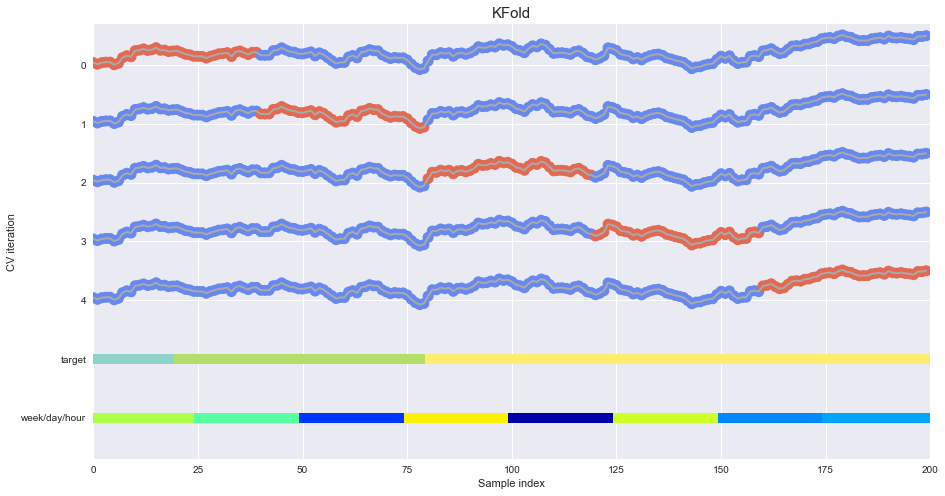

In [18]:
# CV Plotting code modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

# Generate the class/group data
n_points = 200
X_example = np.random.randn(n_points, 1)

percentiles_classes = [.1, .3, .6]
y_example = np.hstack([[ii] * int(n_points * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
n_groups = 8
groups = np.hstack([[ii] * int(n_points/n_groups) for ii in range(int(n_groups))])

n_splits = 5

fig, ax = plt.subplots()
cv1 = KFold(n_splits)

plot_cv_indices(cv1, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour");

And the `TimeSeriesSplit` style CV, notice how the validation set is always later than the training set:

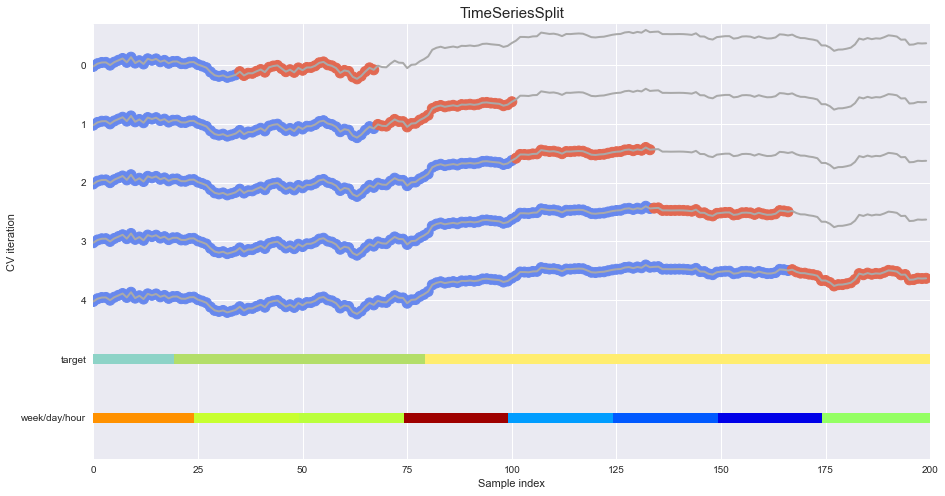

In [19]:
fig,ax=plt.subplots()
cv2 = TimeSeriesSplit(n_splits)
plot_cv_indices(cv2, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour");

In the plots above the bottom row, "week/day/hour" shows how we want to maintain these groups when we do our splits. Concretely, we want to train on a certain set of days pricing, and validate on a completely separate set of days. 

The next concept that comes up is if we are calculating lagged terms such as moving averages, we want to ensure we have a gap between our validation data and our training set. At first this might not be so obvious, but if we look at a moving average with a decent window size we can see that our moving average is going to be carrying information from our training set into our validation set. 

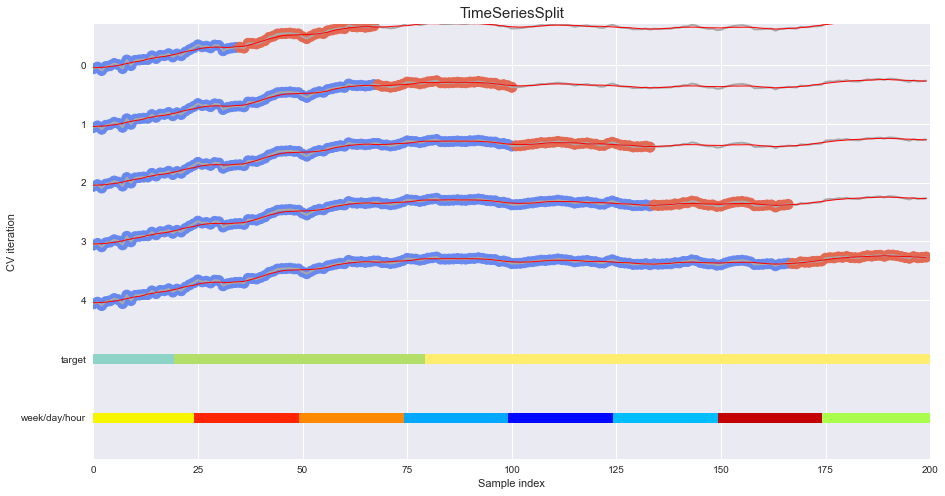

In [20]:
fig,ax=plt.subplots()
plot_cv_indices(cv2, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour", moving_average=10);

Notice how the moving average in red has trends in it that are carrying from the training set (blue) into the validation set (salmon?)...not good!

To solve both of these problems, we use a splitter that will honour a grouping column (i.e days) and will also build a gap in between training set and validation set to prevent carrying trends into the validation set. Thanks to the wonders of the internet (and Kaggle making it easier to share good ideas) - we can use a splitter built for `sklearn` from [here](https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna).

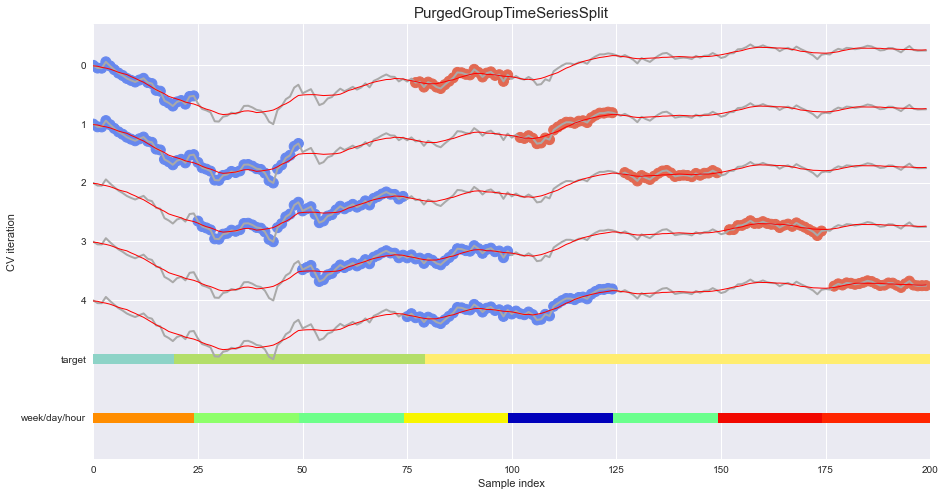

In [21]:
fig,ax=plt.subplots()
cv3 = PurgedGroupTimeSeriesSplit(n_splits, group_gap=2, max_train_group_size=2)
plot_cv_indices(cv3, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour", moving_average=10);

Looks pretty good! All boundaries in our group column at the bottom are honored (i.e each day), and there is a gap between our train and validation sets. The gap width, and max training set size are parameters we need to double check depending on our fitting process. If we have a 100 day moving average being used we may want to have a larger gap than if we were using a 20 day moving average.

## Feature Engineering

Alright - with a solid CV strategy in place and our data split and mostly clean, we are ready to think about adding new features. This is typical of technical analysis of stocks - moving average convergence/divergence (MACD) and relative strength index (RSI) are two prominent examples (read more [here](https://www.investopedia.com/terms/m/macd.asp#)). Put simply, the MACD is looking at exponential moving averages (more recent data is more important) and comparing how they change between different window sizes. RSI looks at current prices in relation to previous highs and lows. For both of these methods, if there is truly a signal to use MACD or RSI to predict pricing machine learning can find it! We can also evaluate numerous different ways of calculting these inputs and see if we can get an accurate model predicting on held out future data (validation set).

First we'll setup some transformers that allow us to quickly scale searching features, and hyperparameter settings for our algorithim in one step. Here we'll use one of the original technical analysis libraries `TA-Lib` which is written in C - but Python bindings can be found [here](https://github.com/mrjbq7/ta-lib). 

Before we go any further, we'll aggregate to hourly data for prototyping on a smaller data set. We can revisit the minute data once we have the pipeline dialed. This takes us from ~2.9M rows down to ~42K rows. We will also change each feature from absolute numbers (open price, close price etc) to a delta from the previous time step (change in open price from previous time step etc). This will allow the model to learn more generalizable features compared to modelling exact price data.

In [33]:
# Build out the correct aggregation from minute -> hour data.
# Using a clunky apply here to get the volume weighted price aggregated correctly
def hourly_agg(x):
    df = {}
    df["open"] = x.open[0]
    df["high"] = x["high"].max()
    df["low"] = x.low.min()
    df["close"] = x.close[-1]
    df["volume_btc"] = x.volume_btc.sum()
    df["volume_currency"] = x.volume_currency.sum()
    df["weighted_price"] = (x.volume_btc * x.weighted_price).sum() / x.volume_btc.sum()

    return pd.Series(
        df,
        index=[
            "open",
            "high",
            "low",
            "close",
            "volume_btc",
            "volume_currency",
            "weighted_price",
        ],
    )


train_df_hourly = (
    train_df.resample("60MIN", closed="left", label="left")
    .apply(hourly_agg)
    .rename({"volume_btc":"volume"}, axis=1)
)

train_df_hourly_delta = (train_df_hourly
    .diff() 
    .dropna()
    .rename({x: f"delta_{x}" for x in train_df.columns}, axis=1)
    )

In [23]:
train_df_hourly.head()

,open,high,low,close,volume_btc,volume_currency,weighted_price
timestamp,,,,,,,
2014-01-01 00:00:00,732.01,739.90,729.01,739.02,595.509638,4.389352e+05,737.074844
2014-01-01 01:00:00,739.02,742.00,737.65,741.89,840.547103,6.222370e+05,740.276164
2014-01-01 02:00:00,741.89,757.99,741.89,747.20,1365.898145,1.023213e+06,749.113611
2014-01-01 03:00:00,747.20,749.61,740.00,744.99,605.941836,4.503270e+05,743.185111
2014-01-01 04:00:00,744.98,749.59,744.98,749.52,218.784294,1.636422e+05,747.961451


In [24]:
train_df_hourly_delta.head()

,delta_open,delta_high,delta_low,delta_close,delta_volume_btc,delta_volume_currency,delta_weighted_price
timestamp,,,,,,,
2014-01-01 01:00:00,7.01,2.10,8.64,2.87,245.037464,183301.811482,3.201321
2014-01-01 02:00:00,2.87,15.99,4.24,5.31,525.351042,400975.906729,8.837447
2014-01-01 03:00:00,5.31,-8.38,-1.89,-2.21,-759.956309,-572885.940805,-5.928500
2014-01-01 04:00:00,-2.22,-0.02,4.98,4.53,-387.157542,-286684.732827,4.776340
2014-01-01 05:00:00,4.54,0.40,0.86,0.38,22.489393,17202.360212,1.579787


In [80]:
from sklearn.base import BaseEstimator, TransformerMixin

# Get ta-lib python bindings, use binary from: 
# https://www.lfd.uci.edu/~gohlke/pythonlibs/
# File: TA_Lib‑0.4.19‑cp38‑cp38‑win_amd64.whl
# $ pip install TA_Lib‑0.4.19‑cp38‑cp38‑win_amd64.whl
from talib.abstract import *

# Setup for the technical indicators
all_indicators_dict = talib.get_function_groups()
all_ta_indicators = [
    x
    for k, v in all_indicators_dict.items()
    for x in all_indicators_dict.get(k)
    if k
    not in [
        "Math Operators",
        "Math Transform",
        "Price Transform",
        "Statistic Functions",
    ]
]

class AddTAIndicators(BaseEstimator, TransformerMixin):
    
    def __init__(self, indicators = all_ta_indicators):
        """
        Add technical indicators from `TA-Lib`. By default adds everything, requires
        X to have open, high, low, close, volume columns.
        
        Parameters
        ----------
        indicators: list
            List of TA-Lib function names from talib.abstract to create as new columns in X
        """
        self.indicators = indicators
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_out = X.copy()
        for ind in self.indicators:
            X_out[ind] = globals()[ind](X)
            
        return X_out
            
           
class RemoveZeroCols(BaseEstimator, TransformerMixin):
    """
    Transformer to remove columns with all 0's in X. 
    """

    def __init__(self):
        return None

    def fit(self, X, y=None):
        self.non_zero_cols = (X != 0).any(axis=0)
        return self

    def transform(self, X, y=None):
        return X.loc[:, self.non_zero_cols]


def snapshot_model(model, path):
    now = datetime.now()
    date_time = now.strftime("%Y_%m_%d_%H_%M_%S")
    dump(model, os.path.join(path, f"{date_time}.joblib"))

In [ ]:
ta_adder = AddTAIndicators()
ta_adder.fit_transform(X=train_df_hourly)

In [259]:
# Setup to evaluate predicting different time shifts.
num_samples = 2000
results = pd.DataFrame()


for shift in [1]:

    # Carefully shift target data one shift ahead. Need `id` to match data up to each timestamp to predict the change in the next timestamp
    y_target = train_df_hourly_delta["delta_close"].shift(-1 * shift).dropna().tail(num_samples)
    x_target = (
        train_df_hourly_delta[train_df_hourly_delta.index.isin(y_target.index)]
        .assign(id=1)
        .reset_index()
        .tail(num_samples)
    )

    # Build CV object - grouping by date....this would be more important on something that isn't traded 24/7 but we'll keep it in!
    groups = x_target.timestamp.dt.date
    splitter = PurgedGroupTimeSeriesSplit(
        3, group_gap=10, max_train_group_size=365, max_test_group_size=100
    )

    # This pipeline assumes the data frame already sorted by `timestamp` column
    search_pipeline = Pipeline(
            ("clf", LGBMRegressor(random_state=42)),
        ]
    )

    param_grid = {
        "ema__days": [[12,100]],
        "windows__max_timeshift": [20],
    }

    grid = GridSearchCV(
        search_pipeline, param_grid=param_grid, cv=splitter, scoring=mase_scorer, refit=True
    )

    grid.fit(x_target, y_target, groups=groups)
    
    results = pd.concat([results, pd.DataFrame(grid.cv_results_).assign(shift= shift)])


Rolling:   0%|          | 0/3 [00:00<?, ?it/s]

 Selecting Relevant Features.....
 Selecting Relevant Features.....
 Selecting Relevant Features.....


Rolling:   0%|          | 0/5 [00:00<?, ?it/s]

0 features found significant out of 3856 possible.


Rolling:   0%|          | 0/8 [00:00<?, ?it/s]

 Selecting Relevant Features.....


Rolling:   0%|          | 0/5 [00:00<?, ?it/s]

0 features found significant out of 3864 possible.


Rolling:   0%|          | 0/13 [00:00<?, ?it/s]

 Selecting Relevant Features.....


Rolling:   0%|          | 0/5 [00:00<?, ?it/s]

5 features found significant out of 3870 possible.


Rolling:   0%|          | 0/20 [00:00<?, ?it/s]

 Selecting Relevant Features.....
 Selecting Relevant Features.....


Feature Extraction: 100%|██████████| 420/420 [14:55<00:00,  2.13s/it]


10 features found significant out of 3870 possible.


In [260]:
pd.DataFrame(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ema__days,param_windows__max_timeshift,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,shift
0,385.725303,202.246806,245.893834,2.030654,"[12, 100]",20,"{'ema__days': [12, 100], 'windows__max_timeshi...",-0.620886,-0.648621,-0.644892,-0.638133,0.01229,1,1


For a visual of time frames we trained on vs. validated on in each iteration:

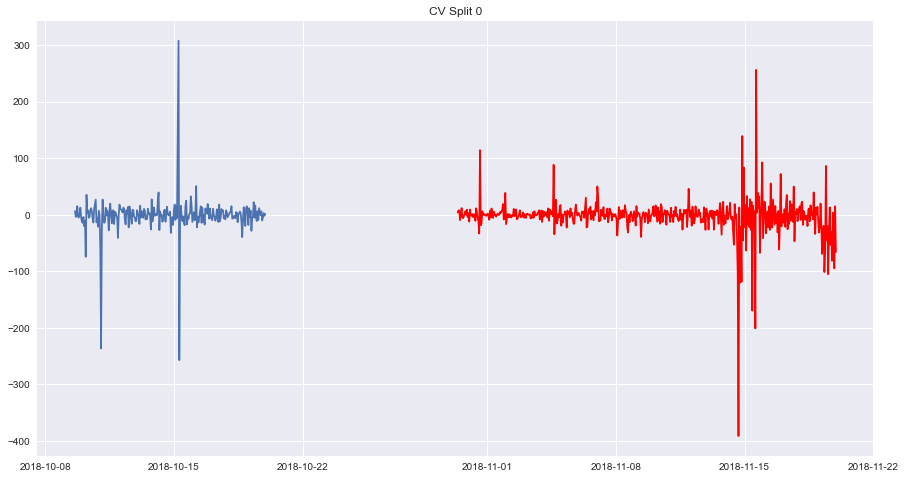

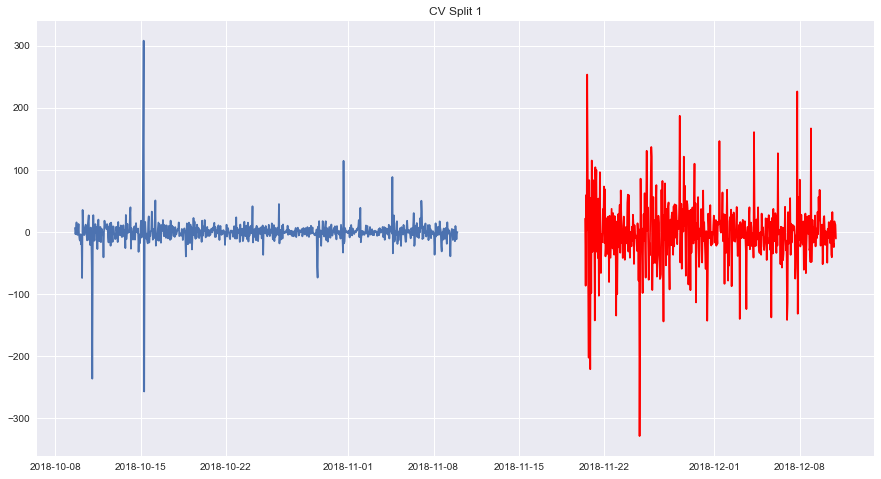

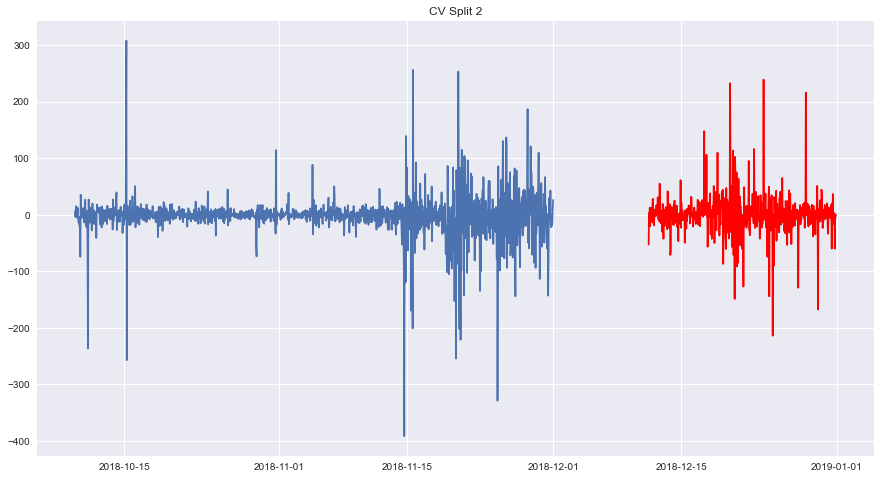

In [261]:
split = 0
for train_ix, test_ix in splitter.split(x_target['delta_close'], y_target, groups):
    fig,ax=plt.subplots()
    ax.plot(x_target.loc[train_ix,'timestamp'],x_target.loc[train_ix,'delta_close'])
    ax.plot(x_target.loc[test_ix,'timestamp'],x_target.loc[test_ix,'delta_close'], c='red')
    ax.set_title(f"CV Split {split}")
    split += 1


Let's look at features selected: